## **EDA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error
import gzip
import json
from copy import deepcopy
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1= []
with gzip.open(r'/content/drive/MyDrive/dataset/Software.json.gz') as f:
    for l in f:
        df1.append(json.loads(l.strip()))
print(len(df1))

459436


In [ ]:
df1=pd.DataFrame(df1)

In [ ]:
from copy import deepcopy
rev=deepcopy(df1)

In [ ]:
rev1=rev.drop(['reviewTime','image','style','vote','reviewText','reviewerName','verified','summary'],axis=1)
rev1.head(3)

,overall,reviewerID,asin,unixReviewTime
0,4.0,A240ORQ2LF9LUI,0077613252,1394496000
1,4.0,A1YCCU0YRLS0FE,0077613252,1393113600
2,1.0,A1BJHRQDYVAY2J,0077613252,1392595200


In [ ]:
rev1.isnull().sum()

overall           0
reviewerID        0
asin              0
unixReviewTime    0
dtype: int64

In [ ]:
#Duplicate Values
from prettytable import PrettyTable
mask_duplicated_reviews = rev1.duplicated(subset=[ "reviewerID", "unixReviewTime",'asin','overall'], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

x = PrettyTable()
x.field_names = ["","Count"]
x.add_rows([["Duplicate Reviews", count_duplicated_reviews[True]], ["Original Reviews", count_duplicated_reviews[False]]])
print(x)

+-------------------+--------+
|                   | Count  |
+-------------------+--------+
| Duplicate Reviews |  8653  |
|  Original Reviews | 450783 |
+-------------------+--------+


In [ ]:
rev1=rev1[-mask_duplicated_reviews]

In [ ]:
rev1.dtypes

overall           float64
reviewerID         object
asin               object
unixReviewTime      int64
dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


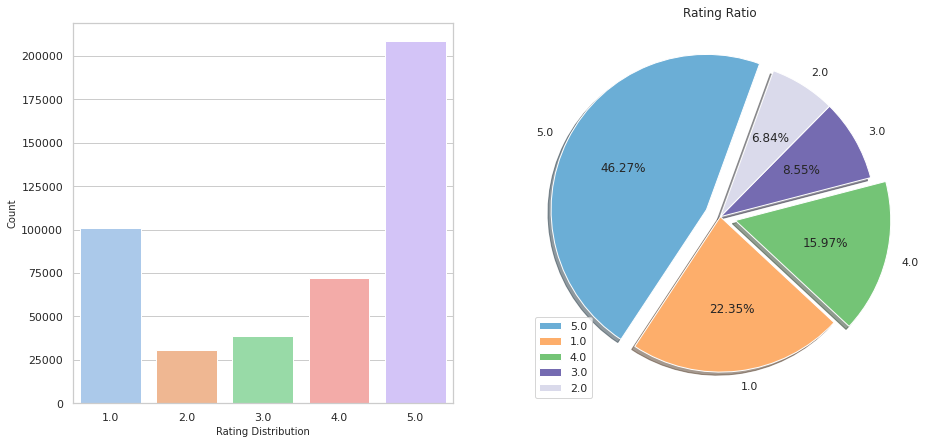

In [ ]:
#Countplot of the ratings, maximum user-products have got rating as 5
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(rev1['overall'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
cmap = plt.get_cmap("tab20c")


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_cnt["Ratings"], explode=explode, labels=rating_cnt.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70,colors = cmap([1,6,9,12,15]))
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_cnt.Labels, loc=3)
plt.show()



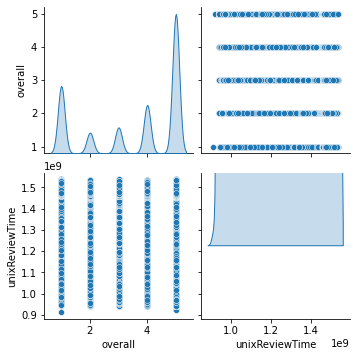

In [ ]:
sns.pairplot(rev1, diag_kind= 'kde')

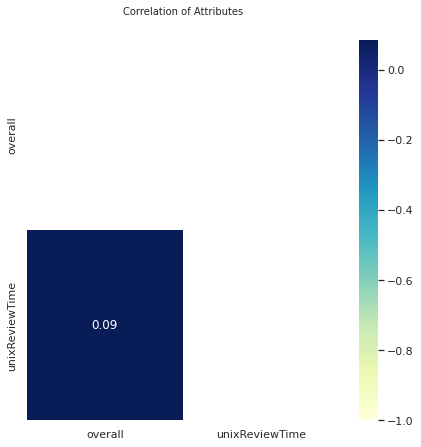

In [ ]:
#Heatmap of timestamp and rating
mask = np.zeros_like(rev1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(7,7))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(rev1.corr(),vmin=-1, cmap='YlGnBu',annot=True,  mask=mask, fmt='.2f')

In [ ]:
#Summary of the data
print("Data Summary....................................................................................")
print("\nTotal number of Ratings :",rev1.shape[0])
print("Total number of Users   :", len(np.unique(rev1.reviewerID)))
print("Total number of Products  :", len(np.unique(rev1.asin)))

Data Summary....................................................................................

Total number of Ratings : 459436
Total number of Users   : 375147
Total number of Products  : 21663


In [ ]:
#Check and find the max ratings given by user for a particular item
max_rat = rev1.groupby(['reviewerID','asin'])['overall'].max().sort_values(ascending=False)
max_rat

reviewerID      asin      
AZZYX9XK6MC8S   B0039Y59F0    5.0
A2Q1D13T2WX7R   B0039L31JY    5.0
A2Q17D58IA8S9R  B00005LINU    5.0
                B00006ELM9    5.0
A2Q17OZM0QX30I  B00UB76290    5.0
                             ... 
A39N24TTLP6I48  B00MUTAY1Y    1.0
A289T4U9P3NQQP  B01617VPUY    1.0
A39N1B4YFI7XHF  B0001DI6F2    1.0
A2VVGS0PXIEWQN  B0001AU6IK    1.0
AEHUG9IMXR350   B00N4OLGP2    1.0
Name: overall, Length: 450578, dtype: float64

In [ ]:
#Check and find the min ratings given by user for a particular item
min_rat = rev1.groupby(['reviewerID','asin'])['overall'].min().sort_values(ascending=False)
min_rat

reviewerID      asin      
AZZYX9XK6MC8S   B0039Y59F0    5.0
A2Q1E3VVB3DA1O  B00IT6WQDQ    5.0
A2Q17D58IA8S9R  B00006ELM9    5.0
A2Q17OZM0QX30I  B00UB76290    5.0
A2Q18PYAMX9ZEW  B00N12N0QK    5.0
                             ... 
AO0LIEHQ87JU0   B00095M0R2    1.0
ADCENJZ4877QD   B00004WJKO    1.0
A1Q40ZIXWKWQ3X  B00T71GS90    1.0
A2SZYP4AFNTTAR  B00004WFVV    1.0
A3LFCD2HRYA125  B00P31G9PQ    1.0
Name: overall, Length: 450578, dtype: float64

In [ ]:

no_rat_each_person = rev1.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_rat_each_person.head(10)

reviewerID
A5JLAU2ARJ0BO     73
A680RUE1FDO8B     71
A225G2TFM76GYX    69
A3W4D8XOGLWUN5    68
A15S4XW3CRISZ5    66
A20DZX38KRBIT8    64
A3VL4RXCWNSR3H    53
A31N0XY2UTB25C    49
A1IU7S4HCK1XK0    42
ANGGNFE8DXGYC     39
Name: overall, dtype: int64

In [ ]:
no_rat_each_person.describe().astype(int)

count    375147
mean          1
std           0
min           1
25%           1
50%           1
75%           1
max          73
Name: overall, dtype: int64

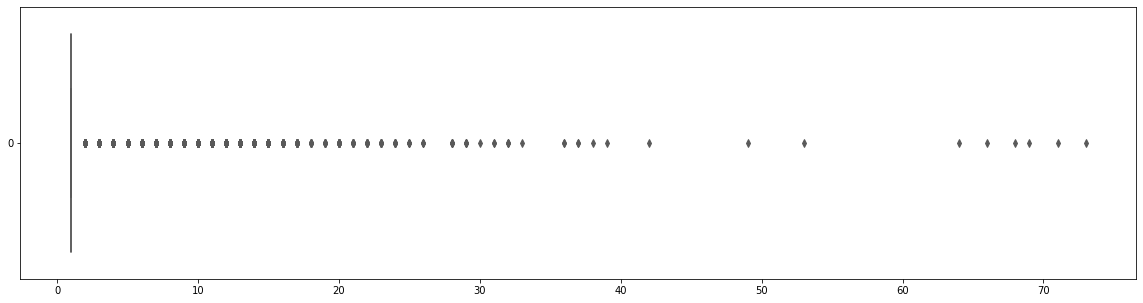

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=no_rat_each_person, orient='h', palette='Set2', dodge=False)

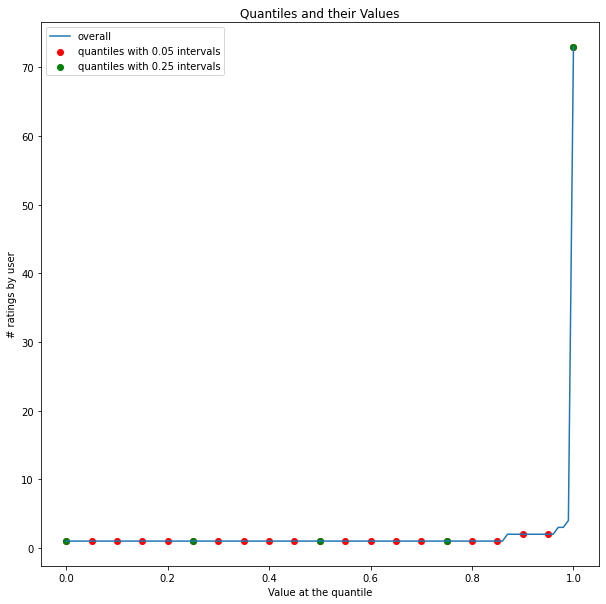

In [ ]:
#We can see that all the ratings are clustered at the top end of the quantile

quantiles = no_rat_each_person.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n number of rated product more than 10 per user : {}\n'.format(sum( no_rat_each_person>=10)) )
new_df=rev1.groupby("reviewerID").filter(lambda x:x['overall'].count() >=10)


 number of rated product more than 10 per user : 517



In [ ]:
#total no. of rating for each person
new_df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_rat_each_person.head(10)

reviewerID
A5JLAU2ARJ0BO     73
A680RUE1FDO8B     71
A225G2TFM76GYX    69
A3W4D8XOGLWUN5    68
A15S4XW3CRISZ5    66
A20DZX38KRBIT8    64
A3VL4RXCWNSR3H    53
A31N0XY2UTB25C    49
A1IU7S4HCK1XK0    42
ANGGNFE8DXGYC     39
Name: overall, dtype: int64

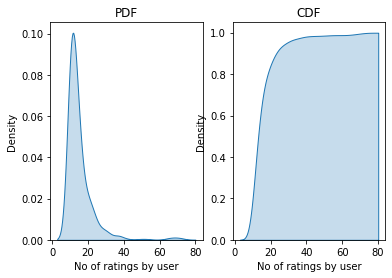

In [ ]:
#PDF and CDF for the number of ratings per user
#PDF is left skewed as majority of the users have given very few ratings
ax1 = plt.subplot(121)
sns.kdeplot(no_rat_each_person, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_rat_each_person2, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

<function matplotlib.pyplot.show>

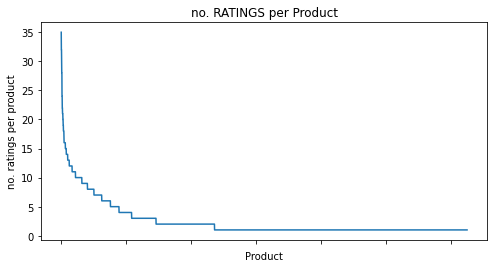

In [ ]:
#plot of number of ratings per product
no_of_ratings_per_product = new_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('no. RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('no. ratings per product')
ax.set_xticklabels([])

plt.show


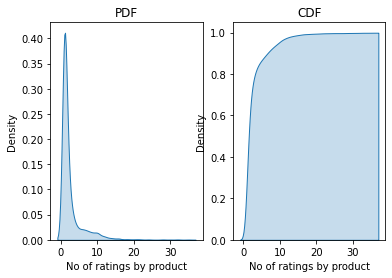

In [ ]:
#PDF and CDF for the number of ratings per product
#PDF is left skewed as majority of the products have very few ratings
ax1 = plt.subplot(121)
sns.kdeplot(no_of_ratings_per_product, shade=True, ax=ax1)
plt.xlabel('No of ratings by product')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_ratings_per_product, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by product')
plt.title('CDF')

plt.show()

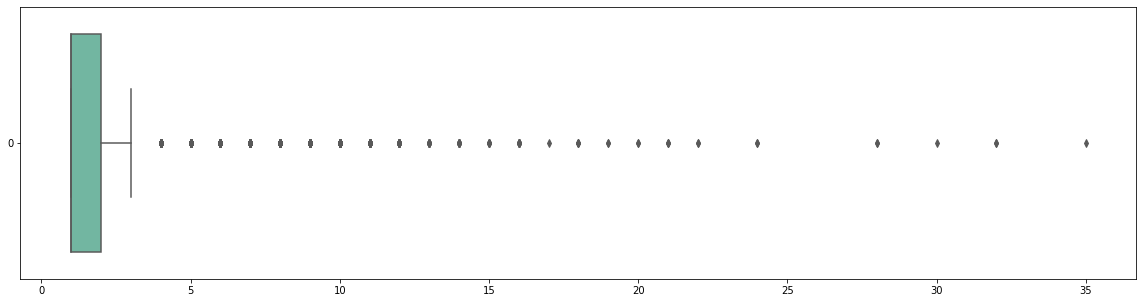

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=no_of_ratings_per_product, orient='h', palette='Set2', dodge=False)

In [ ]:
quantiles = no_of_ratings_per_product.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [ ]:
#Extract Year
def year_extract(reviewTime):
    year = reviewTime[-4:]
    return year

df1['Year'] = df1['reviewTime'].apply(year_extract)

In [ ]:
df1.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Year
0,4.0,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN,2014
1,4.0,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN,2014
2,1.0,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN,2014
3,3.0,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN,2014
4,5.0,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN,2013


In [ ]:
l=df1['Year'].value_counts()
year_count=l.to_frame()

In [ ]:
year_count.rename({'Year':'count'}, axis=1,inplace=True)

In [ ]:
year_count.reset_index(level=0, inplace=True)

In [ ]:
year_count.rename({'index':'year'}, axis=1,inplace=True)
year_count.head(5)

,year,count
0,2015,86324
1,2014,77348
2,2016,66786
3,2013,46663
4,2017,29350


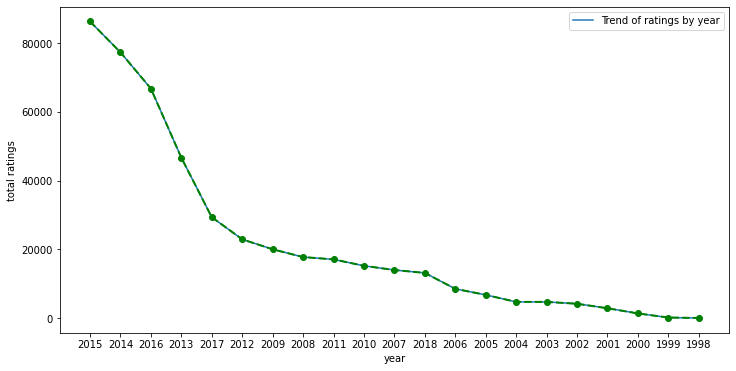

In [ ]:
#year wise total number of sell
import matplotlib.pyplot as plt
  
x = year_count['year']
y = year_count['count']

  
# Plotting the Data
plt.figure(figsize=(12,6))
plt.plot(x, y, label='Trend of ratings by year')
  
plt.xlabel('year')
plt.ylabel('total ratings')
  
plt.plot(y, 'o:g', linestyle='--', linewidth='2')

  
plt.legend()

In [ ]:
#Total no of rating for product
new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B008H3SW4I    35
B000Y7Y6IQ    32
B000X86ZAS    32
B0017KEA6W    30
B0013OAHTG    28
Name: overall, dtype: int64

In [ ]:
#mean rating for a product
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['overall'].mean())

In [ ]:
ratings_mean_count.head(5)

,overall
asin,
0201656302,4.000000
031024837X,3.000000
0321700945,5.000000
0321719816,4.666667
0321719824,4.000000


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())
ratings_mean_count.head(5)

,overall,rating_counts
asin,,
0201656302,4.000000,1
031024837X,3.000000,1
0321700945,5.000000,5
0321719816,4.666667,6
0321719824,4.000000,3


In [ ]:

#Total no of rating for product

new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B008H3SW4I    35
B000Y7Y6IQ    32
B000X86ZAS    32
B0017KEA6W    30
B0013OAHTG    28
Name: overall, dtype: int64

In [ ]:
ratings_mean_count['rating_counts'].max()

35

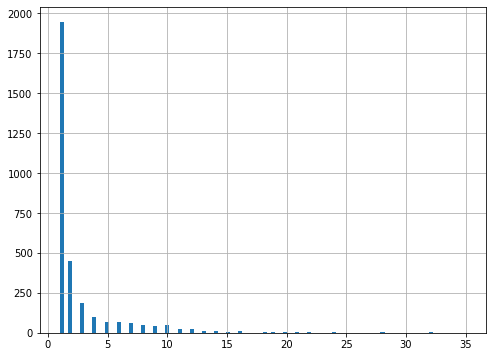

In [ ]:
#Majority of the products have received 1 rating only and it is a right skewed distribution
plt.figure(figsize=(8,6))
ratings_mean_count['rating_counts'].hist(bins=100)

<Figure size 576x432 with 0 Axes>

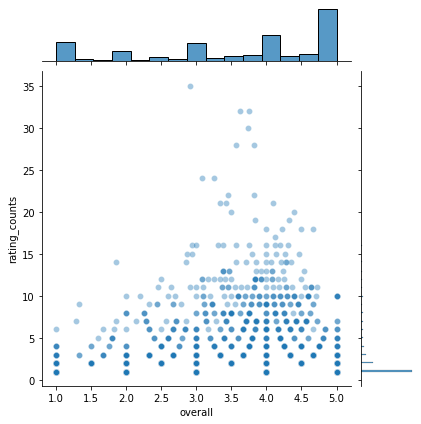

In [ ]:
#From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='overall', y='rating_counts', data=ratings_mean_count, alpha=0.4)


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())

In [ ]:
ratings_mean_count.head()

,overall,rating_counts
asin,,
0201656302,4.000000,1
031024837X,3.000000,1
0321700945,5.000000,5
0321719816,4.666667,6
0321719824,4.000000,3


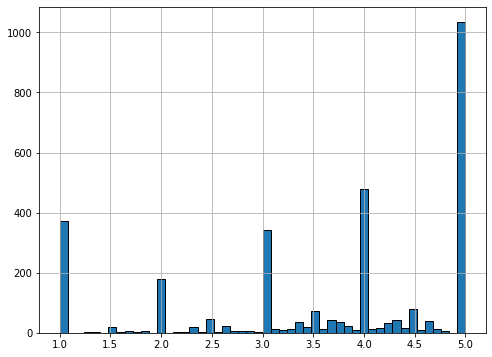

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

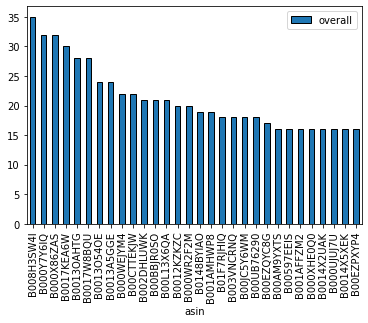

In [ ]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [ ]:
no_of_ratings_per_user = new_df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

#**MODEL (ALS)**

##Importing and Installing Modules

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [ ]:
!pip install pyspark==2.3.0

     |████████████████████████████████| 211.9 MB 56 kB/s 
     |████████████████████████████████| 189 kB 21.2 MB/s 
  Created wheel for pyspark: filename=pyspark-2.3.0-py2.py3-none-any.whl size=212271917 sha256=1a8d74e8a4d6dff20959f1135584429ae6c1cfde764aa20636a071907e2f7380
  Stored in directory: /root/.cache/pip/wheels/c0/ed/08/40a6e0c03e6564ebe4e757a6081779570dd81f73a5817789e6
Successfully built pyspark


In [ ]:
#import module
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gzip
from copy import deepcopy
import time
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error

##DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1= []
with gzip.open(r'/content/drive/MyDrive/dataset/Software.json.gz') as f:
    for l in f:
        df1.append(json.loads(l.strip()))
print(len(df1))
print(df1[0])

459436
{'overall': 4.0, 'verified': True, 'reviewTime': '03 11, 2014', 'reviewerID': 'A240ORQ2LF9LUI', 'asin': '0077613252', 'style': {'Format:': ' Loose Leaf'}, 'reviewerName': 'Michelle W', 'reviewText': "The materials arrived early and were in excellent condition.  However for the money spent they really should've come with a binder and not just loose leaf.", 'summary': 'Material Great', 'unixReviewTime': 1394496000}


In [ ]:
df1= pd.DataFrame.from_dict(df1)

In [ ]:
#create session
appName = "Recommendation system in Spark with ALS"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
df1.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4.0,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1.0,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN


Dropping Duplicates

In [ ]:
ratings = deepcopy(df1)
ratings.drop(['reviewTime','image','style','vote','reviewText','reviewerName','verified','summary'],axis=1, inplace = True)
ratings.fillna(value = 0, inplace = True)
ratings.drop_duplicates
ratings

,overall,reviewerID,asin,unixReviewTime
0,4.0,A240ORQ2LF9LUI,0077613252,1394496000
1,4.0,A1YCCU0YRLS0FE,0077613252,1393113600
2,1.0,A1BJHRQDYVAY2J,0077613252,1392595200
3,3.0,APRDVZ6QBIQXT,0077613252,1392595200
4,5.0,A2JZTTBSLS1QXV,0077775473,1381708800
...,...,...,...,...
459431,2.0,AGEWYJ2NF5C2H,B01HF41TKI,1480377600
459432,1.0,A3VCFV8WEQG9R5,B01HF3G4BS,1519862400
459433,5.0,A3DXGHJF6SOHNC,B01HF3G4BS,1512172800
459434,5.0,A1WOS4D7QA06DO,B01HJAMWOK,1536969600


In [ ]:
dataset=deepcopy(ratings)

In [ ]:
ratings = pd.DataFrame(ratings)

In [ ]:
ratings

,overall,reviewerID,asin,unixReviewTime
0,4.0,A240ORQ2LF9LUI,0077613252,1394496000
1,4.0,A1YCCU0YRLS0FE,0077613252,1393113600
2,1.0,A1BJHRQDYVAY2J,0077613252,1392595200
3,3.0,APRDVZ6QBIQXT,0077613252,1392595200
4,5.0,A2JZTTBSLS1QXV,0077775473,1381708800
...,...,...,...,...
459431,2.0,AGEWYJ2NF5C2H,B01HF41TKI,1480377600
459432,1.0,A3VCFV8WEQG9R5,B01HF3G4BS,1519862400
459433,5.0,A3DXGHJF6SOHNC,B01HF3G4BS,1512172800
459434,5.0,A1WOS4D7QA06DO,B01HJAMWOK,1536969600


In [ ]:
data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
pipeline = Pipeline(stages=indexer)
data = pipeline.fit(data).transform(data)

In [ ]:
transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
transformed_test = data.subtract(transformed_train)

In [ ]:
transformed_train = transformed_train.withColumnRenamed('overall','label')

In [ ]:
transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

In [ ]:
als = ALS(maxIter = 20, regParam = 0.05 ,userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
model = als.fit(transformed_train)

In [ ]:
prediction = model.transform(transformed_test)

In [ ]:
prediction.show(n=5, truncate = False)

+--------------+----------+---------+---------+---------------+----------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|
+--------------+----------+---------+---------+---------------+----------+
|A1V9URY58AWPER|B015724B8M|5.0      |148.0    |25547.0        |2.6606545 |
|A6MTID98B0AKC |B015724B8M|5.0      |148.0    |38137.0        |2.0765257 |
|A3DXYKQQSRYOP1|B015724B8M|5.0      |148.0    |2684.0         |2.7836654 |
|AMI1R66JNJUG  |B015724B8M|5.0      |148.0    |25308.0        |3.469737  |
|A1XE6OH8G5P071|B015724B8M|1.0      |148.0    |21246.0        |0.6473868 |
+--------------+----------+---------+---------+---------------+----------+
only showing top 5 rows



In [ ]:
evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error(RMSE):", rmse)

Root Mean Square Error(RMSE): 2.0535236271669035


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split 

ratings=deepcopy(dataset)

#ratings,rat = train_test_split(ratings1, test_size=0.5, stratify=ratings['overall'])

In [ ]:
dataset

,overall,reviewerID,asin,unixReviewTime
0,4.0,A240ORQ2LF9LUI,0077613252,1394496000
1,4.0,A1YCCU0YRLS0FE,0077613252,1393113600
2,1.0,A1BJHRQDYVAY2J,0077613252,1392595200
3,3.0,APRDVZ6QBIQXT,0077613252,1392595200
4,5.0,A2JZTTBSLS1QXV,0077775473,1381708800
...,...,...,...,...
459431,2.0,AGEWYJ2NF5C2H,B01HF41TKI,1480377600
459432,1.0,A3VCFV8WEQG9R5,B01HF3G4BS,1519862400
459433,5.0,A3DXGHJF6SOHNC,B01HF3G4BS,1512172800
459434,5.0,A1WOS4D7QA06DO,B01HJAMWOK,1536969600


In [ ]:
ratings

,overall,reviewerID,asin,unixReviewTime
0,4.0,A240ORQ2LF9LUI,0077613252,1394496000
1,4.0,A1YCCU0YRLS0FE,0077613252,1393113600
2,1.0,A1BJHRQDYVAY2J,0077613252,1392595200
3,3.0,APRDVZ6QBIQXT,0077613252,1392595200
4,5.0,A2JZTTBSLS1QXV,0077775473,1381708800
...,...,...,...,...
459431,2.0,AGEWYJ2NF5C2H,B01HF41TKI,1480377600
459432,1.0,A3VCFV8WEQG9R5,B01HF3G4BS,1519862400
459433,5.0,A3DXGHJF6SOHNC,B01HF3G4BS,1512172800
459434,5.0,A1WOS4D7QA06DO,B01HJAMWOK,1536969600


In [ ]:
ratings = pd.DataFrame(ratings)
overall_group= ratings.groupby('overall')
rating_5= overall_group.get_group(5.0)
count_five = len(rating_5)
def oversampling(subset):
    count = len(subset)
    n=int(count_five/count)
    return (n)

In [ ]:
n1 = overall_group.get_group(1.0)
one_rating = overall_group.get_group(1.0)
rat_1= pd.concat([one_rating]*oversampling(one_rating),ignore_index=True)

n2 = overall_group.get_group(1.0)
two_rating = overall_group.get_group(2.0)
rat_2= pd.concat([two_rating]*oversampling(two_rating),ignore_index=True)

n3 = overall_group.get_group(1.0)
three_rating = overall_group.get_group(3.0)
rat_3= pd.concat([three_rating]*oversampling(three_rating),ignore_index=True)

n4 = overall_group.get_group(1.0)
four_rating = overall_group.get_group(4.0)
rat_4= pd.concat([four_rating]*oversampling(four_rating),ignore_index=True)

rat_5=rating_5

In [ ]:
oversampled_data= pd.concat([rat_5,rat_4,rat_3,rat_2,rat_1])
oversampled_data= oversampled_data.sample(frac=1,random_state=42)
oversampled_data

,overall,reviewerID,asin,unixReviewTime
33059,4.0,AW4NGZEU2JGUQ,B00E6LIECA,1392940800
72114,2.0,A1X48MIR1ZOJVO,B005GI19HY,1339372800
142090,2.0,A3T53VYOX6NZKZ,B00H8MEYAA,1467936000
128039,3.0,A1OJOO7XLMU4PI,B004E9SKBO,1326067200
176427,1.0,A114F6AZE915CC,B01617VO2S,1491177600
...,...,...,...,...
46726,4.0,A32SBMJDRACRA7,B00MYXTCGY,1424822400
6194,3.0,A19CCUWRGO8FA4,B001AFD8XK,1248652800
285305,5.0,A1BLE5KSEUN2RF,B00NG7JVSQ,1423612800
114536,2.0,A21PIC72GNKTWQ,B00P6U8C5Y,1427587200


In [ ]:
dataset['overall'].value_counts()

5.0    212452
1.0    102548
4.0     73596
3.0     39395
2.0     31445
Name: overall, dtype: int64

In [ ]:
oversampled_data['overall'].value_counts()

5.0    212452
1.0    205096
3.0    196975
2.0    188670
4.0    147192
Name: overall, dtype: int64

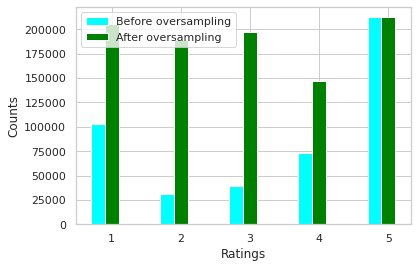

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = np.arange(5)
y1 = [102548,31445,39395,73596,212452]
y2 = [205096,188670,196975,147192,212452]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='green')

plt.xticks(x, ['1', '2', '3', '4', '5'])
plt.xlabel("Ratings")
plt.ylabel("Counts")
plt.legend(["Before oversampling", "After oversampling"])
plt.show()

In [ ]:
ratings=deepcopy(oversampled_data)

####Stratified Split

In [ ]:
data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
pipeline = Pipeline(stages=indexer)
data = pipeline.fit(data).transform(data)

In [ ]:
transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
transformed_test = data.subtract(transformed_train)

In [ ]:
transformed_train = transformed_train.withColumnRenamed('overall','label')
transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

####ALS

In [ ]:
als = ALS(maxIter = 20, regParam = 0.05 ,userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
model = als.fit(transformed_train)

In [ ]:
prediction = model.transform(transformed_test)

In [ ]:
evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error(RMSE):", rmse)

Root Mean Square Error(RMSE): 2.3925697303579483


In [ ]:
ratings=deepcopy(dataset)

In [ ]:
# Tuning the parameters to find the minimum RMSE value by optimizing iterations and regular parameters
Score=[]
maxIter=[5,10,15]
regParam=[0.10,0.20,0.30,0.40]
rank=[5,10]
for j in maxIter:
    for i in regParam:
        for k in rank:
        
            als = ALS(rank=k, maxIter = j, regParam = i, userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
            model = als.fit(transformed_train)
            prediction = model.transform(transformed_test)
            #prediction.show(n=5, truncate = False)

            evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
            rmse = evaluator.evaluate(prediction)
            print("Root Mean Square Error(RMSE):", rmse)
            l=[]
            l.append(j)
            l.append(i)
            l.append(rmse)
            l.append(k)
            Score.append(l)
score=[]
for i in range(len(Score)):
    score.append(Score[i][2])

min_Score=min(score)
for i in range(len(Score)):
    if Score[i][2]==min_Score:
        iter=Score[i][0]
        para=Score[i][1]
        rank=Score[i][3]
r=rank

Root Mean Square Error(RMSE): 2.139913247835257
Root Mean Square Error(RMSE): 2.1758539499529292
Root Mean Square Error(RMSE): 1.9420217797455677
Root Mean Square Error(RMSE): 1.9320821985268353
Root Mean Square Error(RMSE): 1.9014186780004072
Root Mean Square Error(RMSE): 1.900201639933592
Root Mean Square Error(RMSE): 1.9069064969335077
Root Mean Square Error(RMSE): 1.91958745383036
Root Mean Square Error(RMSE): 1.9898523984650514
Root Mean Square Error(RMSE): 1.996470592180278
Root Mean Square Error(RMSE): 1.83815732653708
Root Mean Square Error(RMSE): 1.8287125261293276
Root Mean Square Error(RMSE): 1.79129863378282
Root Mean Square Error(RMSE): 1.7898841188693466
Root Mean Square Error(RMSE): 1.7823450391849245
Root Mean Square Error(RMSE): 1.7875184873521301
Root Mean Square Error(RMSE): 1.9249030026678657
Root Mean Square Error(RMSE): 1.9135248069405377
Root Mean Square Error(RMSE): 1.8029613808642035
Root Mean Square Error(RMSE): 1.7910524617806618
Root Mean Square Error(RMSE):

In [ ]:
S=[]
maxIter=[5,10,15]
regParam=[0.10,0.20,0.30,0.40]
rank=[5,10]
c=0
for j in maxIter:
    for i in regParam:
        for k in rank:
            S.append([k,j,i,score[c]])
            c=c+1


In [ ]:

df = pd.DataFrame(S, columns =['Rank', 'maxIter','Regpara','RMSE'])

In [ ]:
df[12:]

,Rank,maxIter,Regpara,RMSE
12,5,10,0.3,1.791299
13,10,10,0.3,1.789884
14,5,10,0.4,1.782345
15,10,10,0.4,1.787518
16,5,15,0.1,1.924903
17,10,15,0.1,1.913525
18,5,15,0.2,1.802961
19,10,15,0.2,1.791052
20,5,15,0.3,1.764881
21,10,15,0.3,1.760079


User based recommendation

In [ ]:
def reco_user(id):
    temp_df = prediction.filter(prediction["reviewerID"] == id)
    temp_df = temp_df.sort("prediction", ascending=False)
    temp_df.show(n= 5, truncate = False)

In [ ]:
reco_user("A1V9URY58AWPER")

+--------------+----------+---------+---------+---------------+----------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|
+--------------+----------+---------+---------+---------------+----------+
|A1V9URY58AWPER|B015724B8M|5.0      |148.0    |25547.0        |4.17324   |
+--------------+----------+---------+---------+---------------+----------+



In [ ]:
df_metadata= []
with gzip.open(r'/content/drive/MyDrive/dataset/meta_Software.json.gz') as f:
    for l in f:
        df_metadata.append(json.loads(l.strip()))
print(len(df_metadata))
print(df_metadata[0])

26790
{'category': [], 'tech1': '', 'description': [], 'fit': '', 'title': 'HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK CONCEPTS', 'also_buy': [], 'tech2': '', 'brand': 'HOLT. RINEHART AND WINSTON', 'feature': [], 'rank': '25,550 in Software (', 'also_view': [], 'main_cat': 'Software', 'similar_item': '', 'date': '</div>', 'price': '.a-box-inner{background-color:#fff}#alohaBuyBoxWidget .selected{background-color:#fffbf3;border-color:#e77600;box-shadow:0 0 3px rgba(228,121,17,.5)}#alohaBuyBoxWidget .contract-not-available{color:gray}#aloha-cart-popover .aloha-cart{height:auto;overflow:hidden}#aloha-cart-popover #aloha-cartInfo{float:left}#aloha-cart-popover #aloha-cart-details{float:right;margin-top:1em}#aloha-cart-popover .deviceContainer{width:160px;float:left;padding-right:10px;border-right:1px solid #ddd}#aloha-cart-popover li:last-child{border-right:0}#aloha-cart-popover .aloha-device-title{height:3em;overflow:hidden}#aloha-cart-popover .aloha-thumbnail-container{height:100px;mar

In [ ]:
df_metadata= pd.DataFrame.from_dict(df_metadata)

In [ ]:
df_metadata

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],,HOLT. RINEHART AND WINSTON,[],"25,550 in Software (",[],Software,,</div>,.a-box-inner{background-color:#fff}#alohaBuyBo...,0030672120,[],[],NaN
1,[],,"[, <b>Latin rhythms that will get your kids si...",,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",[],,McGraw Hill,[],"15,792 in Software (",[],Software,,</div>,,0071480935,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,[],,[<b>Connect is the only integrated learning sy...,,Connect with LearnSmart Access Card for Microb...,[],,McGraw-Hill Science/Engineering/Math,[],"16,900 in Software (",[],Software,,</div>,,007329506X,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
3,[],,[],,LearnSmart Standalone Access Card for Prescott...,[],,McGraw-Hill Education,[],"12,986 in Software (",[],Software,,</div>,,0073513458,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,[],,[<i>Anatomy &amp; Physiology Revealed Cat</i> ...,,Anatomy &amp; Physiology Revealed Student Acce...,"[0323394612, 0323227937, 1118527488]",,McGraw-Hill Education,[],"14,861 in Software (",[],Software,,</div>,$4.83,0073525758,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26785,"[Software, Children's]",,[<b>Features: </b><br>1. Beautiful and fabulou...,,925 Sterling Silver Angel Wings Heart Pendant ...,"[B07B4B12JX, B008UX1WJ2]",,17maimeng,[Material: Guaranteed 100% Real Silver+Platinu...,"1,389,844 in Clothing, Shoes & Jewelry (","[B008UX1WJ2, B0094JVCKU, B077J3DR69, B07J4Z659...","<img src=""https://images-na.ssl-images-amazon....",,17maimeng,$24.00,B01HEFZJC2,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
26786,"[Software, Children's, Material: Guaranteed 10...",,[<b>Features: </b><br>1. Beautiful and fabulou...,,925 Sterling Silver Love Heart Opal Pendant Ne...,[],,17maimeng,[Material: Guaranteed 100% Real Silver+Platinu...,"1,469,307 in Clothing, Shoes & Jewelry (","[B074M486S8, B01D4H965K, B077L7GGF4, B019D8X0W...","<img src=""https://images-na.ssl-images-amazon....",,17maimeng,$23.20,B01HEFZKEE,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
26787,"[Software, Digital Software, Antivirus & Secur...",,[<div>Mac Internet Security X9 contains two of...,,Intego Mac Internet Security X9 - 1 Mac - 1 ye...,[],,Intego,[Award-winning antivirus software to protect a...,"2,733 in Software (","[B01MF5MTWP, B015724B8M, B07CYFFH4H, B07CY54KL...",Software,,</div>,$39.99,B01HF3G4BS,[],[],"{'Downloading:': 'Currently, this item is avai..."
26788,[],,[VersaCheck X9 for QuickBooks 2016 DNA Secure ...,,VersaCheck X9 Small and Medium Business 2016 3...,[],,Diversified Productivity Solutions Ltd,[],"15,575 in Software (",[],Software,,</div>,$24.39,B01HF41TKI,[],[],"{'Shipping Weight:': '1.3 pounds', 'ASIN:': 'B..."


In [ ]:
product_info = deepcopy(df_metadata)
# Taking the necessary columns
product_info = product_info[['asin', 'title', 'category']]
# Replace all null values by 0
product_info.fillna(value = 0, inplace = True)
# Drop all the duplicate values
product_info.drop_duplicates
product_info
# Replacing the empty lists in Category to NaN
for i in range(len(product_info)):
    if product_info['category'][i]==[]:
        product_info['category'][i]=np.nan
# Drop NaN values
product_info.dropna(inplace=True)


In [ ]:
product_info

,asin,title,category
11,007742817X,Instructor's Resource CD-ROM for The Art of Sp...,"[Software, Education &amp; Reference]"
54,0078605407,Como te va? Middle school Spanish Level A Teac...,"[Software, Education &amp; Reference, Languages]"
55,0130438480,Magruder's American Government Resource Pro CD...,"[Software, Education &amp; Reference]"
57,0130852414,Prentice Hall Test Manager a Comprehensive Sui...,"[Software, Education & Reference, Test Prepara..."
58,0131433172,Applied Calculus Lecture Series VHS,"[Software, Education &amp; Reference]"
...,...,...,...
26784,B01HD1CQPK,Women Bohemian Neck Tie Vintage Printed Ethnic...,"[Software, Photography, Waistline:Natural , Ne..."
26785,B01HEFZJC2,925 Sterling Silver Angel Wings Heart Pendant ...,"[Software, Children's]"
26786,B01HEFZKEE,925 Sterling Silver Love Heart Opal Pendant Ne...,"[Software, Children's, Material: Guaranteed 10..."
26787,B01HF3G4BS,Intego Mac Internet Security X9 - 1 Mac - 1 ye...,"[Software, Digital Software, Antivirus & Secur..."


In [ ]:
prod = deepcopy(product_info)

In [ ]:
prod_title=prod[['asin', 'title']]

In [ ]:
prod

,asin,title,category
11,007742817X,Instructor's Resource CD-ROM for The Art of Sp...,"[Software, Education &amp; Reference]"
54,0078605407,Como te va? Middle school Spanish Level A Teac...,"[Software, Education &amp; Reference, Languages]"
55,0130438480,Magruder's American Government Resource Pro CD...,"[Software, Education &amp; Reference]"
57,0130852414,Prentice Hall Test Manager a Comprehensive Sui...,"[Software, Education & Reference, Test Prepara..."
58,0131433172,Applied Calculus Lecture Series VHS,"[Software, Education &amp; Reference]"
...,...,...,...
26784,B01HD1CQPK,Women Bohemian Neck Tie Vintage Printed Ethnic...,"[Software, Photography, Waistline:Natural , Ne..."
26785,B01HEFZJC2,925 Sterling Silver Angel Wings Heart Pendant ...,"[Software, Children's]"
26786,B01HEFZKEE,925 Sterling Silver Love Heart Opal Pendant Ne...,"[Software, Children's, Material: Guaranteed 10..."
26787,B01HF3G4BS,Intego Mac Internet Security X9 - 1 Mac - 1 ye...,"[Software, Digital Software, Antivirus & Secur..."


In [ ]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
sparkDF=spark.createDataFrame(prod.astype(str))

In [ ]:
jdf = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")

In [ ]:
jdf.show(n=5,truncate=False)

+--------------+----------+---------+---------+---------------+----------+----------+-------------------------------------+-----------------------------------------------------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|asin      |title                                |category                                             |
+--------------+----------+---------+---------+---------------+----------+----------+-------------------------------------+-----------------------------------------------------+
|A202XF80BSSDP1|0838447384|5.0      |6310.0   |47726.0        |1.4457204 |0838447384|Triple Play Plus Spanish             |['Software', 'Education & Reference', 'Languages']   |
|A19KIFU4YXG3E1|B00005NCJ3|5.0      |809.0    |2177.0         |2.4438908 |B00005NCJ3|Jasc Paint Shop Pro 7.0 [OLD VERSION]|['Software', 'Design & Illustration', 'Illustration']|
|A19KIFU4YXG3E1|B00005NCJ3|5.0      |809.0    |2177.0         |2.4438908 |B00005NCJ3|Jasc Paint Shop Pro 7.0 [

In [ ]:
from copy import deepcopy
meta_copy=deepcopy(prod)

In [ ]:
meta_copy=meta_copy[['asin','category']]

In [ ]:
meta_copy

,asin,category
11,007742817X,"[Software, Education &amp; Reference]"
54,0078605407,"[Software, Education &amp; Reference, Languages]"
55,0130438480,"[Software, Education &amp; Reference]"
57,0130852414,"[Software, Education & Reference, Test Prepara..."
58,0131433172,"[Software, Education &amp; Reference]"
...,...,...
26784,B01HD1CQPK,"[Software, Photography, Waistline:Natural , Ne..."
26785,B01HEFZJC2,"[Software, Children's]"
26786,B01HEFZKEE,"[Software, Children's, Material: Guaranteed 10..."
26787,B01HF3G4BS,"[Software, Digital Software, Antivirus & Secur..."


In [ ]:
meta_list=meta_copy.values.tolist()
meta_list[:10]

[['007742817X', ['Software', 'Education &amp; Reference']],
 ['0078605407', ['Software', 'Education &amp; Reference', 'Languages']],
 ['0130438480', ['Software', 'Education &amp; Reference']],
 ['0130852414', ['Software', 'Education & Reference', 'Test Preparation']],
 ['0131433172', ['Software', 'Education &amp; Reference']],
 ['0131817949', ['Software', 'Education &amp; Reference', 'Test Preparation']],
 ['0131892320', ['Software', 'Education &amp; Reference']],
 ['0132147556',
  ['Software', 'Business &amp; Office', 'Business &amp; Marketing Plans']],
 ['0201656302', ['Software', 'Design &amp; Illustration', 'CAD']],
 ['0205064833', ['Software', 'Programming & Web Development', 'Web Design']]]

In [ ]:
type(meta_list[1][1])

list

In [ ]:
meta_list[1][1][1]

'Education &amp; Reference'

In [ ]:
category_list=[]
for i in range(len(meta_list)):
    s=[]
    s.append(meta_list[i][0]) 
    s.append(meta_list[i][1][1])
    category_list.append(s)

In [ ]:
df_cat_asin=pd.DataFrame(category_list)

In [ ]:
df_cat_asin

In [ ]:
df_cat_asin.rename({0:'asin',1:'category_type'}, axis=1,inplace=True)

In [ ]:
df_cat_asin.head(5)

,asin,category_type
0,007742817X,Education &amp; Reference
1,0078605407,Education &amp; Reference
2,0130438480,Education &amp; Reference
3,0130852414,Education & Reference
4,0131433172,Education &amp; Reference


In [ ]:
df_inner = pd.merge(df1,df_cat_asin, on='asin', how='inner')

df_inner.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,category_type
0,4.0,True,"08 15, 2011",AGN3T5ERYJN5A,0132147556,{'Format:': ' Paperback'},Skipper management,"Strong backgroung, good read, quite up to date...",E-marketing 6th ed,1313366400,NaN,NaN,Business &amp; Office
1,3.0,False,"10 9, 2010",AHPK2GD0SQC59,0132147556,{'Format:': ' Paperback'},dstmars,If you live on Mars and never heard of the int...,Mars calling Earth....what is internet?,1286582400,NaN,NaN,Business &amp; Office
2,5.0,False,"10 3, 2010",A35UC8LHA6TILH,0132147556,{'Format:': ' Paperback'},Knw1989,i got this book on amazon and it ended up savi...,"good book, saved me a lot of money",1286064000,NaN,NaN,Business &amp; Office


In [ ]:
df_inner['category_type'].value_counts()

Digital Software                     102242
Business & Office                     49606
Antivirus & Security                  49601
Lifestyle & Hobbies                   32101
Accounting & Finance                  31727
Children's                            29541
Operating Systems                     29199
Education & Reference                 27989
Utilities                             26124
Video                                 15618
Photography                           14087
Design & Illustration                 10256
Music                                  7152
Business &amp; Office                  7122
Education &amp; Reference              6733
Networking & Servers                   5596
Programming & Web Development          4206
Tax Preparation                        3600
Lifestyle &amp; Hobbies                3321
Networking &amp; Servers               2727
Antivirus &amp; Security               2219
Accounting &amp; Finance               2160
Design &amp; Illustration       

In [ ]:
df_inner.drop(df_inner[df_inner['category_type']=='Games'].index, inplace=True)

In [ ]:
prod1 = deepcopy(df_inner)
prod2 = prod1[['asin', 'category_type']]

###recommendation category wise

In [ ]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
sparkDF=spark.createDataFrame(prod2.astype(str))

In [ ]:
jdf2 = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")

In [ ]:
ratings2 = deepcopy(df_inner)
ratings2.drop([ 'verified', 'reviewTime', 
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style'],axis=1, inplace = True)
ratings2.fillna(value = 0, inplace = True)
ratings2.drop_duplicates
ratings2

,overall,reviewerID,asin,category_type
0,4.0,AGN3T5ERYJN5A,0132147556,Business &amp; Office
1,3.0,AHPK2GD0SQC59,0132147556,Business &amp; Office
2,5.0,A35UC8LHA6TILH,0132147556,Business &amp; Office
3,5.0,A2IH0AJPR7IWG3,0132147556,Business &amp; Office
4,5.0,AL87GELNJGOH3,0132147556,Business &amp; Office
...,...,...,...,...
465074,5.0,A191CFFASXPOFE,B01HEFZJC2,Children's
465075,1.0,A3VCFV8WEQG9R5,B01HF3G4BS,Digital Software
465076,5.0,A3DXGHJF6SOHNC,B01HF3G4BS,Digital Software
465077,5.0,A1WOS4D7QA06DO,B01HJAMWOK,Lifestyle & Hobbies


In [ ]:
l=df_inner['category_type'].unique()
#l

In [ ]:
def preprocessed(data,r,iter,para):
    #preprocessed = ratings2.values.tolist()
    ##temp_data=data.loc[data['category_type']==cat]
    ##dff=pd.DataFrame(temp_data)
    ##temp_data_f=dff.drop(['category_type'],axis=1)
    
    data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
    indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
    pipeline = Pipeline(stages=indexer)
    data = pipeline.fit(data).transform(data)

    transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
    transformed_test = data.subtract(transformed_train)

    transformed_train = transformed_train.withColumnRenamed('overall','label')
    transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

    als = ALS(rank=r, maxIter = iter, regParam = para, userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
    model = als.fit(transformed_train)
    prediction = model.transform(transformed_test)
    jdf2 = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")
    jdf2=jdf2.dropDuplicates(['reviewerID','asin','truelabel','asinindex','reviewerIDindex','prediction','asin','category_type'])
    #jdf2.show(n=5,truncate=False)
    return(jdf2)

In [ ]:
def reco_user_category(user_id,cat,data,title,r,iter,para):
    temp_data=data.loc[data['category_type']==cat]
    dff=pd.DataFrame(temp_data)
    temp_data_f=dff.drop(['category_type'],axis=1)

    prediction=preprocessed(temp_data,r,iter,para)
    temp_df = prediction.filter(prediction["reviewerID"] == user_id)
    temp_df = temp_df.sort("prediction", ascending=False)
    pandas_df = temp_df.select("*").toPandas()
    #print(pandas_df)
    if len(pandas_df)<5:
        #popularity based
        ratings = pd.DataFrame(temp_data_f.groupby('asin')['overall'].median().sort_values(ascending=False).head())
        #print(ratings)
        ratings=pd.DataFrame(ratings)
        ratings.reset_index(inplace=True)
        #print(ratings)
        #print(ratings.columns)
        #print(type(ratings))
        
        recommendation=ratings[:5]
       # print(recommendation)
       # ratings.rename(columns={"overall": "Rating_Median"}, inplace=True)  
        l1=pandas_df.loc[:,'asin']
        #print(l1)
        l2=recommendation.loc[:,'asin']
        #print(l2)
        reco=l1.values.tolist()
        for i in l2.values.tolist():
            if i not in l1.values.tolist():
                reco.append(i)
            if len(reco)==5:
                break

    else:
       reco=pandas_df['asin'][:5]
    df = pd.DataFrame(reco)
    df.rename(columns={0: "asin"},inplace=True)
    recommend = pd.merge(df,title, on='asin', how='inner').drop_duplicates( keep='last')

    return(recommend)

In [ ]:
reco_user_category('A35UC8LHA6TILH','Lifestyle & Hobbies',ratings2,prod_title,r,iter,para)

,asin,title
0,B01HJAMWOK,CNC Designs - Vector Graphics for Computer Con...
1,B001O4DED6,Horse EPS Vector Sign Clipart Horses
2,B0017XHKYI,Archie Bronze Age Series
3,B0017I3DP8,Corel Family Pack 2009 [Old Version]
4,B0016HIIVY,Cook'n in India


In [ ]:
list_category=df_inner['category_type'].unique()
for i in list_category[:4]:
    print(i)
    print(reco_user_category('A20SG9ZGIIFW69',i,ratings2,prod_title,r,iter,para))
   

Business &amp; Office
         asin                                    title
1  B00005IA4J                Ultimate Business Planner
2  B00080JV4I           Time2Log downloadable Software
4  B00006A6XR  FineReader 6.0 Professional OCR Upgrade
6  B000069IL6        Microsoft Works 7.0 [Old Version]
7  B000A1GY9A  Microsoft Office XP 2002 Small Business
Education & Reference
         asin                                              title
0  B01GK2QBXG  6 Month Firearms Guide 9th Edition ONLINE with...
2  B00006AW2Z          Rosetta Stone Latin Level 1 [Old Version]
4  B000063CWU  Rosetta Stone Global Traveler (Spanish French ...
5  B002BDKUW2                            Inspiration Version 7.5
7  B000063W5A                        Satview 5.0-Student Version
Children's
         asin                                           title
1  B00029BOSQ                       Mighty Math Number Heroes
3  B0000639VT  Butt-Ugly Martians: Martian Boot Camp - PC/Mac
4  B000EXS4B0           Jumpstart Advan

###Cross category

In [ ]:
df_item_info = pd.merge(prod_title,df_cat_asin, on='asin', how='inner')

df_item_info.head(3)

,asin,title,category_type
0,007742817X,Instructor's Resource CD-ROM for The Art of Sp...,Education &amp; Reference
1,0078605407,Como te va? Middle school Spanish Level A Teac...,Education &amp; Reference
2,0130438480,Magruder's American Government Resource Pro CD...,Education &amp; Reference


In [ ]:
def popular(data):
    l=data['category_type'].unique()
    list_rec=[]
    for cat in l:
        temp_data=data.loc[data['category_type']==cat]
        dff=pd.DataFrame(temp_data)
        temp_data_f=dff.drop(['category_type'],axis=1)
        ratings = pd.DataFrame(temp_data_f.groupby('asin')['overall'].median().sort_values(ascending=False).head())
        ratings=pd.DataFrame(ratings)
        ratings.reset_index(inplace=True)
        
        recommendation=ratings[:5]
        l1=recommendation.loc[:,'asin']
        reco=l1.values.tolist()
        for i in reco:
            list_rec.append(i)
    return(list_rec)

In [ ]:
def reco_user_cross_category(user_id,data,item,r,iter,para):
    

    user_list=data['reviewerID']
    user=[]
    for i in user_list:
        user.append(i)

    if user_id in user:
    
        user_subset=data.groupby('reviewerID')
        user_data=user_subset.get_group(user_id)
        user_category=user_data['category_type']
        cat_list=[]
        for i in user_category:
            if i not in cat_list:
                 cat_list.append(i)
        print('recommended categories for previous user',cat_list)
        for i in cat_list:
            print(i)
            print(reco_user_category(user_id,i,ratings2,prod_title,r,iter,para))

    else:
    
        top_rec=popular(data)
        print('recommendation for new user',top_rec)
    


In [ ]:
type(prod_title)

pandas.core.frame.DataFrame

In [ ]:
prod_title_list=prod_title.values.tolist()
prod_df=pd.DataFrame(prod_title_list)
print(type(prod_df),prod_df)

<class 'pandas.core.frame.DataFrame'>                 0                                                  1
0      007742817X  Instructor's Resource CD-ROM for The Art of Sp...
1      0078605407  Como te va? Middle school Spanish Level A Teac...
2      0130438480  Magruder's American Government Resource Pro CD...
3      0130852414  Prentice Hall Test Manager a Comprehensive Sui...
4      0131433172                Applied Calculus Lecture Series VHS
...           ...                                                ...
24722  B01HD1CQPK  Women Bohemian Neck Tie Vintage Printed Ethnic...
24723  B01HEFZJC2  925 Sterling Silver Angel Wings Heart Pendant ...
24724  B01HEFZKEE  925 Sterling Silver Love Heart Opal Pendant Ne...
24725  B01HF3G4BS  Intego Mac Internet Security X9 - 1 Mac - 1 ye...
24726  B01HJAMWOK  CNC Designs - Vector Graphics for Computer Con...

[24727 rows x 2 columns]


In [ ]:
l=reco_user_cross_category('A20SG9ZGIIFW69',ratings2,r,iter,para)

recommended categories for previous user ['Lifestyle & Hobbies']
Lifestyle & Hobbies
         asin                                              title
0  B01HJAMWOK  CNC Designs - Vector Graphics for Computer Con...
1  B001O4DED6               Horse EPS Vector Sign Clipart Horses
2  B0017XHKYI                           Archie Bronze Age Series
3  B0017I3DP8               Corel Family Pack 2009 [Old Version]
4  B0016HIIVY                                    Cook'n in India


In [ ]:
l=reco_user_cross_category('monalisa',ratings2,prod_title,r,iter,para)

recommendation for new user ['B00005IA4J', 'B00080JV4I', 'B00006A6XR', 'B000069IL6', 'B000A1GY9A', 'B01GK2QBXG', 'B00006AW2Z', 'B000063CWU', 'B002BDKUW2', 'B000063W5A', 'B00029BOSQ', 'B0000639VT', 'B000EXS4B0', 'B0000645W2', 'B0000645WE', 'B01FW8597I', 'B000B8GTME', 'B000LLV45I', 'B000LMHB3Q', 'B000MN8OZI', 'B000AJFZJC', 'B000059RR8', 'B00004T2UL', 'B0001IQQ0E', 'B00004U1QH', '007742817X', '5864551287', '2749006724', 'B000637S74', '2749004322', 'B01GDD4968', 'B001NX55XK', 'B001QDQZO0', 'B001S4T1NO', 'B001TL2ZD4', 'B001JBDVK0', 'B0002CU1QO', 'B00009MJDF', 'B00009RTNX', 'B0000C120L', '0740311034', 'B000T2N7MW', 'B001AWHGK4', 'B001BI4D80', 'B001DBGRRK', 'B01HJAMWOK', 'B001O4DED6', 'B0017XHKYI', 'B0017I3DP8', 'B0016HIIVY', 'B01H4KS63G', 'B009JX5XZQ', 'B009YKXPCC', 'B009VKZMQ2', 'B000MAODR4', 'B00GUWAL4W', 'B00IR13K06', 'B000CO3IBC', 'B00F1T97B8', 'B00F3RN94E', 'B003XVQ77S', 'B003L51CZ8', 'B003EYU5BI', 'B00021XI8I', 'B00022VMV2', 'B00130I0EO', 'B001AMLQ6O', 'B0017OBMBO', 'B0018PH9Z0', 'B001